In [9]:
import cobra 
#from pytfa.thermo.equilibrator import build_thermo_from_equilibrator,compute_dGf,compound_to_entry
#import equilibrator_cache
from cobra import Model, Reaction, Metabolite
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import straindesign as sd
#from equilibrator_api import ComponentContribution,Q_
import os
import pytfa
from optlang.exceptions import SolverError
from cobra.flux_analysis import flux_variability_analysis
from cobra.io import load_matlab_model, load_json_model,load_model
from pytfa.io import import_matlab_model, load_thermoDB,                    \
                            read_lexicon, annotate_from_lexicon,            \
                            read_compartment_data, apply_compartment_data
from pytfa.optim.variables import LogConcentration, \
    ThermoDisplacement,DeltaG
from pytfa.analysis.sampling import sample
from pytfa.optim.utils import strip_from_integer_variables
from pytfa.analysis.variability import variability_analysis
from pytfa.analysis import apply_reaction_variability, apply_generic_variability
#from pytfa.thermo.equilibrator import build_thermo_from_equilibrator,compute_dGf,compound_to_entry

## Load Ecoli core

In [10]:
model = load_json_model('e_coli_core.json')
reactions=pd.read_csv('reactions.csv',header=0,index_col=0)
thermo_data = load_thermoDB('./pytfa/data/thermo_data.thermodb')

## Impose anaerobic conditions

In [11]:
model.reactions.EX_o2_e.bounds=(0,1000)
solution=model.optimize()

In [12]:
model_toy=model
model_toy.solver='cplex'

## Add metabolites and reactions

In [21]:
mapping_table=str.maketrans({'-':'','+':'', '>':'','<':''})
metabolites=[]
for i in reactions.index:
    dummy= str(reactions.loc[i]['formula'])
    dummy=dummy.translate(mapping_table)
    dummy=dummy.split()
    for e in dummy:
        if len(e)>2:
            metabolites.append(e)

metabolites = list(set(metabolites))

for b in metabolites:
    if b not in model_toy.metabolites:
        print(b)
        model_toy.add_metabolites([cobra.Metabolite(b, compartment='c')])

print(metabolites)
model_toy.metabolites.get_by_id('1btol_e').compartment='e'     

['1btol_c', 'h_c', 'accoa_c', 'h2o_c', '3hbcoa_c', 'btcoa_c', '1btol_e', 'nadh_c', 'btal_c', 'ctncoa_c', 'coa_c', 'nad_c', 'aacoa_c']


In [22]:
model_toy.metabolites.get_by_id('ctncoa_c').annotation= { 'SeedID': 'cpd00650', 'KeggID': 'C00877'}
model_toy.metabolites.get_by_id('1btol_e').annotation= { 'SeedID': 'cpd03662','KeggID': 'C06142' }
model_toy.metabolites.get_by_id('1btol_c').annotation= { 'SeedID': 'cpd03662','KeggID': 'C06142'}
model_toy.metabolites.get_by_id('3hbcoa_c').annotation= { 'SeedID': 'cpd00842','KeggID': 'C01144'}
model_toy.metabolites.get_by_id('btal_c').annotation= { 'SeedID': 'cpd01011','KeggID': 'C01412'}
model_toy.metabolites.get_by_id('btcoa_c').annotation= { 'SeedID': 'cpd00120','KeggID': 'C00136'}
model_toy.metabolites.get_by_id('aacoa_c').annotation= { 'SeedID': 'cpd00279','KeggID': 'C00332'}

In [23]:
for i in reactions.index:
        reac=i
        reac=cobra.Reaction(i)
        model_toy.add_reactions([reac])
        reac.reaction= str(reactions.loc[i]['formula'])
    

Ignoring reaction 'R1' since it already exists.
C:\Users\jiraj\anaconda3\envs\myenv\lib\site-packages\cobra\core\reaction.py:1567: UserWarning: no model found
  warn("no model found")


AttributeError: 'NoneType' object has no attribute 'metabolites'

## Create Thermo model

In [24]:
thermo_data = load_thermoDB('./pytfa/data/thermo_data.thermodb')
EPSILON = 1e-9
tmodel=tfa.ThermoModel(thermo_data,model_toy)
lexicon = read_lexicon('lexicon.csv')
compartment_data = read_compartment_data('compartment_data.json')
annotate_from_lexicon(tmodel, lexicon)
apply_compartment_data(tmodel, compartment_data)
tmodel.prepare()
tmodel.convert(add_displacement=True)
model_toy=tmodel
print("Reactions:")
for reaction in model_toy.reactions:
    print(reaction.id, reaction.reaction)

solution = model_toy.optimize()
print("Objective value:", solution.objective_value)

2023-10-03 13:03:45,183 - thermomodel_None - INFO - # Model initialized with units kcal/mol and temperature 298.15 K
2023-10-03 13:03:45,840 - thermomodel_None - INFO - # Model initialized with units kcal/mol and temperature 298.15 K
2023-10-03 13:03:45,847 - thermomodel_None - WARNING - glc__D_e  not found in annotations
2023-10-03 13:03:45,848 - thermomodel_None - WARNING - gln__L_c  not found in annotations
2023-10-03 13:03:45,851 - thermomodel_None - WARNING - gln__L_e  not found in annotations
2023-10-03 13:03:45,852 - thermomodel_None - WARNING - glu__L_c  not found in annotations
2023-10-03 13:03:45,854 - thermomodel_None - WARNING - glu__L_e  not found in annotations
2023-10-03 13:03:45,855 - thermomodel_None - WARNING - lac__D_c  not found in annotations
2023-10-03 13:03:45,856 - thermomodel_None - WARNING - lac__D_e  not found in annotations
2023-10-03 13:03:45,858 - thermomodel_None - WARNING - mal__L_c  not found in annotations
2023-10-03 13:03:45,862 - thermomodel_None - W

Reactions:
PFK atp_c + f6p_c --> adp_c + fdp_c
PFL coa_c + pyr_c --> accoa_c + for_c
PGI g6p_c <=> f6p_c
PGK 3pg_c + atp_c + h_c <=> 13dpg_c + adp_c
PGL 6pgl_c + h2o_c --> 6pgc_c + h_c
ACALD acald_c + coa_c + nad_c <=> accoa_c + h_c + nadh_c
AKGt2r akg_e + h_e <=> akg_c + h_c
PGM 2pg_c <=> 3pg_c
PIt2r h_e + pi_e <=> h_c + pi_c
ALCD2x etoh_c + nad_c <=> acald_c + h_c + nadh_c
ACALDt acald_e <=> acald_c
ACKr ac_c + atp_c + h_c <=> actp_c + adp_c
PPC co2_c + h2o_c + pep_c --> 2.0 h_c + oaa_c + pi_c
ACONTa cit_c <=> acon_C_c + h2o_c
ACONTb acon_C_c + h2o_c <=> icit_c
ATPM atp_c + h2o_c --> adp_c + h_c + pi_c
PPCK atp_c + h_c + oaa_c --> adp_c + co2_c + pep_c
ACt2r ac_e + h_e <=> ac_c + h_c
PPS atp_c + h2o_c + pyr_c --> amp_c + h_c + pep_c + pi_c
ADK1 amp_c + atp_c <=> 2.0 adp_c
AKGDH akg_c + coa_c + nad_c --> co2_c + nadh_c + succoa_c
ATPS4r adp_c + 4.0 h_e + pi_c <=> atp_c + h2o_c + 3.0 h_c
PTAr accoa_c + h_c + pi_c <=> actp_c + coa_c
PYK adp_c + pep_c --> atp_c + pyr_c
BIOMASS_Ecoli_core

## TVA Results

2023-10-03 13:00:12,074 - thermomodel_None - INFO - Beginning variability analysis for variable of type <class 'pytfa.optim.variables.LogConcentration'>
maximizing: 100%|██████████| 79/79 [00:01<00:00, 73.66it/s]
2023-10-03 13:00:13,781 - thermomodel_None - INFO - Beginning variability analysis for variable of type reaction
maximizing: 100%|██████████| 103/103 [00:01<00:00, 87.38it/s]


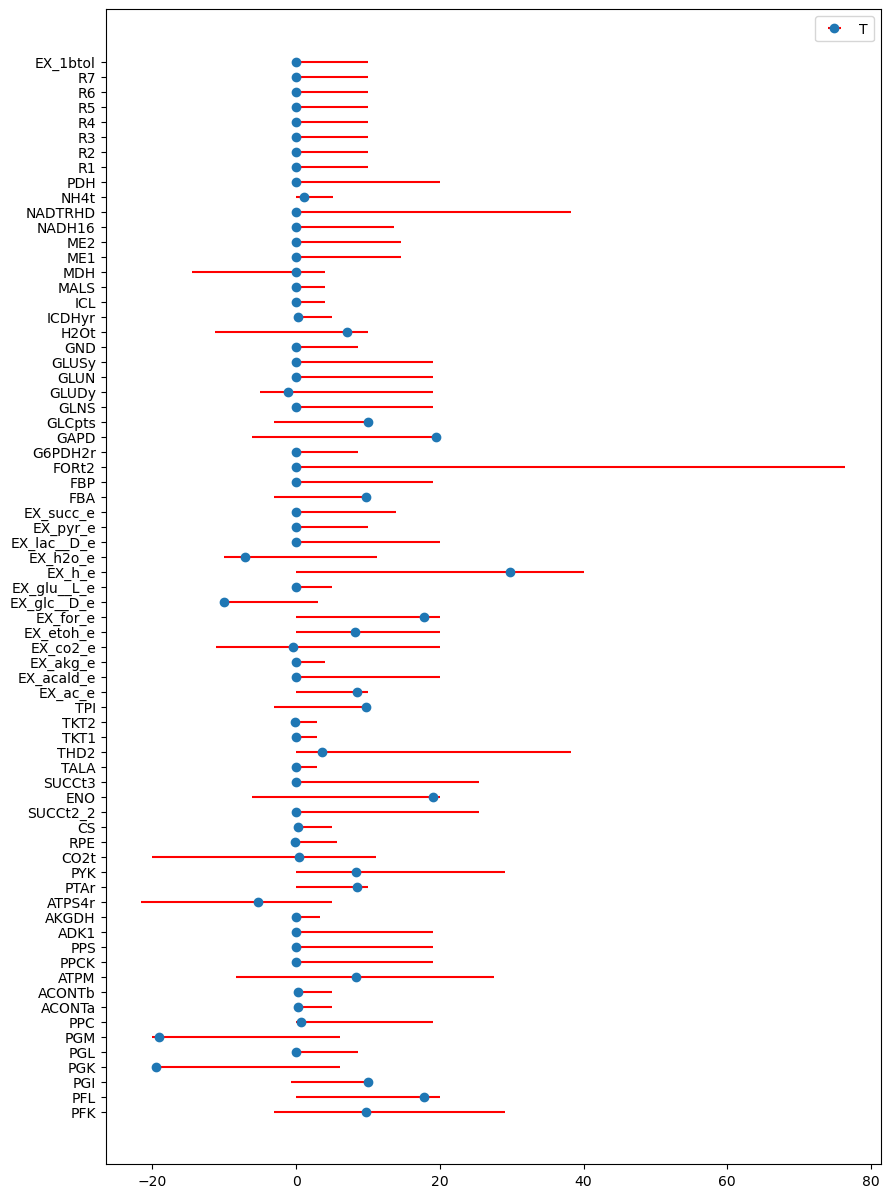

In [17]:
thermo_vars = [LogConcentration]
tva_thermo = variability_analysis(model_toy, kind=thermo_vars)
apply_generic_variability(model_toy, tva_thermo, inplace=True)


solution=model_toy.optimize()
tva_fluxes = variability_analysis(model_toy, kind='reaction')
df=[]
threshold=1

plt.figure(figsize=(10,15))
df=tva_fluxes.drop(['FRD7','SUCDi'], axis='index')
df=df[abs(df['maximum'])>=threshold]
df['mean']=solution.fluxes
x=df.index.map(str)
y=df['mean']
error=[abs(df['minimum'].values)+df['mean'].values,abs(df['maximum'].values)-df['mean'].values]
plt.tight_layout()
plt.errorbar(y, x, xerr=error, fmt='o', ecolor='red')

plt.legend('TVA RESULTS')
plt.show()

## Theoretical Yield 

In [20]:
model_toy.reactions.EX_o2_e.bounds=(0,1000)
model_toy.objective='EX_1btol'
solution=model_toy.optimize()
the_yield="{:.0%}".format(solution.objective_value/abs(model_toy.reactions.EX_glc__D_e.lower_bound))
print('The theoretical yield', the_yield)
model_toy.objective='BIOMASS_Ecoli_core_w_GAM'
solution=model_toy.optimize()
print(solution)

The theoretical yield 100%
<Solution 0.214 at 0x2c1642090d0>
